# Colour Detection Robot

This workbook contains the code that controls a colour detecting and following robot.

The following peripherals are attached to the PYNQ board:
        • DC Motor
        • TI L293 Half H-Driver
        • Sharp GP2D120 proximity sensor
        • Advent USB Webcam
        • External Power Source
        
        
This initial section of the workbook imports all of the modules required for the rest of the pr

In [1]:
'''from pynq import Overlay
Overlay("base.bit").download()'''
#from pynq.drivers.video import Frame
from pynq.iop import Arduino_IO
from pynq.iop import ARDUINO

from IPython.display import clear_output
from matplotlib import pyplot as plt
from PIL import Image as PIL_Image

from ipywidgets import *
from IPython import display

import numpy as np
import argparse
import cv2
import time

In this secion of the program the set up of the connected devices is carried out.

The pins of the motor controller and ultrasonic sensor are defined using the PYNQ's Arduino_IO module.

The pixel width and height of the USB webcam is set and the image capture from the webcam begins

In [2]:
#Motor 1
m1_enable = Arduino_IO(ARDUINO, 7, 'out')
m1_left = Arduino_IO(ARDUINO, 6, 'out')
m1_right = Arduino_IO(ARDUINO, 5, 'out')

#Motor 2
m2_enable = Arduino_IO(ARDUINO, 8, 'out')
m2_left = Arduino_IO(ARDUINO, 9, 'out')
m2_right = Arduino_IO(ARDUINO, 10, 'out')

#Ultrasonic sensor 1
TRIG1 = Arduino_IO(ARDUINO, 4, 'out')
#ECHO1 = Arduino_IO(ARDUINO, 3, 'in')

frame_in_w = 640
frame_in_h = 480

videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);

print("capture device is open: " + str(videoIn.isOpened()))

capture device is open: True


This is the method that checks the distance ahead of the robot

In [3]:
def getDistance():
    #global pulse_start, pulse_end, pulse_duration
    pulse_start = 0
    pulse_end = 0
    pulse_duration = 0
    print ("Distance measurement in progress")

    distance = 0
    TRIG1.write(0)
    print ("Waiting For Sensor #1 To Settle")
    time.sleep(1)
    
    
    TRIG1.write(1)
    time.sleep(0.00001)
    TRIG1.write(0)
    
    while ECHO1.read() == 0:
        pulse_start = time.time()

    while ECHO1.read() == 1: 
        pulse_end = time.time()
    
    try:
        pulse_duration = pulse_end - pulse_start
        distance = pulse_duration * 17150

        distance = round(distance, 2)    
    
        return distance
        
    except UnboundLocalError:
        print("Error", end = '\r')
        pass
    
    return -1

Here is the function that contains the invinate while loop that detects the above colour in the webcam's image and controls the robot's motors depending if and where in the image the desired colour is detected

In [4]:
def colour_follower (b):
    try:

        #Takes in the value that the user has seleced using the sliders and sets those values as the 
        #upper and lower values for the pixel detection
        lower = np.array([lower_hue.value, lower_saturation.value, lower_value.value], dtype = "uint8")
        upper = np.array([upper_hue.value, upper_saturation.value, upper_value.value], dtype = "uint8")


        frame_number = 0


        while(True): 
        #for i in range(0,10):
            m1_enable.write(0) #Motor #1 enable pin
            m2_enable.write(0) #Motor #1 enable pin

            #Reads in new frame from camera
            ret, frame_vga = videoIn.read()

            #Converts frame to HSV format and creates a mask using the upper and lower colour settings
            converted = cv2.cvtColor(frame_vga, cv2.COLOR_BGR2HSV)
            skinMask = cv2.inRange(converted, lower, upper)

            #Elliptical structuring kernel created and two iterations of erosions and dilations are carried
            #out to reduce the risk of any pixels being falsely detected as skin
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
            skinMask = cv2.erode(skinMask, kernel, iterations = 2)
            skinMask = cv2.dilate(skinMask, kernel, iterations = 2)

            #Apply gaussian blurring to the mask to reduce any noise before appling the mask to the frame
            skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
            skin = cv2.bitwise_and(frame_vga, frame_vga, mask = skinMask)

            #Divide the original image into three equal parts, left, center and right
            left = frame_vga[0:480, 0:213]
            center = frame_vga[0:480, 213:426]
            right = frame_vga[0:480, 426:680]

            #Divide the mask into three equal parts, left, center and right
            left_skin = skinMask[0:480, 0:213]
            center_skin = skinMask[0:480, 213:426]
            right_skin = skinMask[0:480, 426:680]

            #Display the left section of the image
            #plt.imshow(left_skin)
            #plt.show()

            #Calculate and print the percentage of pixels detected as skin versus the total number
            #of pixels within this section of the frame
            lft_blkpxls = round(cv2.countNonZero(left_skin)/(640*480)*100, 2)
            print("Percentage of non-black pixels in left: ", lft_blkpxls)

            #Display the center section of the image
            #plt.imshow(center_skin)
            #plt.show()

            #Calculate and print the percentage of pixels detected as skin versus the total number
            #of pixels within this section of the frame
            center_blkpxls = round(cv2.countNonZero(center_skin)/(640*480)*100, 2)
            print("Percentage of non-black pixels in center: ", center_blkpxls)

            #Display the right section of the image
            #plt.imshow(right_skin)
            #plt.show()

            #Calculate and print the percentage of pixels detected as skin versus the total number
            #of pixels within this section of the frame
            rgt_blkpxls = round(cv2.countNonZero(right_skin)/(640*480)*100, 2)
            print("Percentage of non-black pixels in right: ", rgt_blkpxls)


            plt.imshow(np.hstack([frame_vga, skin]))
            #plt.imshow(skin)
            plt.show()

            #Calculate and print the percentage of pixels detected as skin versus 
            #the total number of pixels in the frame
            frameArray = skinMask[0:480, 0:680]
            totalblkpxls =  round(cv2.countNonZero(frameArray)/(640*480)*100, 2)
            print("Percentage of non-black pixels: ", totalblkpxls)

            #Outputs the frame number
            frame_number = frame_number + 1
            print("Frame Number: ", frame_number)

            #If the percentage of pixels is below 10%, the robot will not move
            if(totalblkpxls < 5):
                print("Not enough colour to follow....adjusting")
                m1_enable.write(1) #enable
                m1_left.write(0)
                m1_right.write(1)

                m2_enable.write(1) #enable
                m2_left.write(1)
                m2_right.write(0)
                time.sleep(0.5)
            else:
                distanceAhead = 11
                #distanceAhead = getDistance()
                print("Distance Ahead", distanceAhead)
                print("Above Threshold")
                
                if distanceAhead < 0 or distanceAhead > 500:
                    print("Sensor Malfunction - Sensor Reading:", distanceAhead)
                elif distanceAhead < 10:
                    print("Path obstructed, object", distanceAhead, " away")
                else:
                    print("Path clear")
                    #If the majority of the detected pixels are in the left section of the 
                    #frame, the robot will adjust itself and move towards the detected colour
                    if (lft_blkpxls > center_blkpxls and lft_blkpxls > rgt_blkpxls):
                        print("Adjusting Left")
                        m1_enable.write(1) #enable
                        m1_left.write(0)
                        m1_right.write(1)

                        m2_enable.write(1) #enable
                        m2_left.write(1)
                        m2_right.write(0)

                        time.sleep(0.25)

                        m1_enable.write(1) #enable
                        m1_left.write(0)
                        m1_right.write(1)

                        m2_enable.write(1) #enable
                        m2_left.write(0)
                        m2_right.write(1)

                        time.sleep(2)

                    #If the majority of the detected pixels are in the center section of the 
                    #frame, the robot will move towards the detected colour    
                    elif(center_blkpxls > lft_blkpxls and center_blkpxls > rgt_blkpxls):
                        print("Going Straight Ahead")
                        m1_enable.write(1) #enable
                        m1_left.write(0)
                        m1_right.write(1)

                        m2_enable.write(1) #enable
                        m2_left.write(0)
                        m2_right.write(1)

                        time.sleep(2)

                    #If the majority of the detected pixels are in the right section of the 
                    #frame, the robot will adjust itself and move towards the detected colour
                    elif(rgt_blkpxls > center_blkpxls and rgt_blkpxls > lft_blkpxls):
                        print("Adjusting Right")
                        m1_enable.write(1) #enable
                        m1_left.write(1)
                        m1_right.write(0)

                        m2_enable.write(1) #enable
                        m2_left.write(0)
                        m2_right.write(1)

                        time.sleep(0.25)

                        m1_enable.write(1) #enable
                        m1_left.write(0)
                        m1_right.write(1)

                        m2_enable.write(1) #enable
                        m2_left.write(0)
                        m2_right.write(1)

                        time.sleep(2)
                    #Default case    
                    else:
                        print("Default")
                        time.sleep(2)

            #Wait here until the image is cleared
            clear_output(wait=True)
    except KeyboardInterrupt:
        videoIn.release()

Here the range of the pixel colours that the webcam will detect are set (HSV format):
    - skin is a difficult colour to detect because of light conditions and different skin tones so a 
    slider is setup so the user can select the range they want to detect.
    
    - the sliders were initially used to find the range of values which represent skin

In [5]:
lower_hue = widgets.IntSlider(min=0, max=179, value=0, description = "Lower Hue")
lower_saturation = widgets.IntSlider(min=0, max=255, value=48, description = "Lower Saturation")
lower_value = widgets.IntSlider(min=0, max=255, value=80, description = "Lower Value")

upper_hue = widgets.IntSlider(min=0, max=179, value=20, description = "Upper Hue")
upper_saturation = widgets.IntSlider(min=0, max=255, value=255, description = "Upper Saturation")
upper_value = widgets.IntSlider(min=0, max=255, value=255, description = "Upper Value")

Sets up the button that starts the colour following robot and sets up the sliders

In [6]:
slider_container = widgets.HBox([widgets.VBox([lower_hue, lower_saturation, lower_value]), 
      
      widgets.VBox([upper_hue, upper_saturation, upper_value])], background_color='#EEE')

strt_colourfollower = widgets.Button(description="Start")
strt_colourfollower.width = "120px"
strt_colourfollower.background_color = "#FFFF00" 

Displays the sliders and button

Percentage of non-black pixels in left:  0.0
Percentage of non-black pixels in center:  0.0
Percentage of non-black pixels in right:  0.0


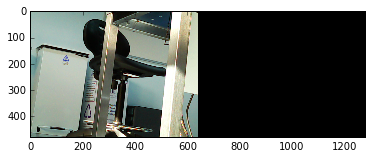

Percentage of non-black pixels:  0.0
Frame Number:  19
Not enough colour to follow....adjusting


In [7]:
strt_colourfollower.on_click(colour_follower)

display.display(slider_container)
display.display(strt_colourfollower)